# [LEGALST-190] Lab 4/5: Word2Vec & PCA

In this lab, we will implement a Word2Vec algorithm on a sample of the UN General Debates dataset and conduct Principle Component Analysis of the resulting word embeddings. 

*Estimated Time: 45 minutes*

### Table of Contents

[Overview](#section context)<br>

[The Data](#section data)<br>

0- [Pre-Processing](#section 0)<br>

1 - [Word2Vec](#section 1)<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1 - [Training](#subsection 1)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2 - [Embeddings](#subsection 2)

2- [PCA of Word Embeddings](#section 2)<br>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1 - [Plot Word Vectors Using PCA](#subsection 3)


__Dependencies:__

In [1]:
import pandas as pd
import numpy as np

!pip install nltk
import nltk
!pip install gensim
import gensim
import string

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


#nltk.download() #to get the stopwords corpus

/Users/jmarshall/anaconda3/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


## Overview <a id='context'></a>

In this lab, we will be turning individual words in the data set into vectors, called "Word Embeddings". Word embedding generally attempts to identify semantic relationships between words by observing them in the context that the word appears. Word2Vec is the most prominent word embedding algorithm - this is what we will have practice using in today's lab.

Imagine that each word in a novel has its meaning determined by the ones that surround it in a limited window. For example, in Moby Dick's first sentence, “me” is paired on either side by “Call” and “Ishmael.” After observing the windows around every word in the novel (or many novels), the computer will notice a pattern in which “me” falls between similar pairs of words to “her,” “him,” or “them.” Of course, the computer had gone through a similar process over the words “Call” and “Ishmael,” for which “me” is reciprocally part of their contexts.  This chaining of signifiers to one another mirrors some of humanists' most sophisticated interpretative frameworks of language.

The two main flavors of Word2Vec are CBOW (Continuous Bag of Words) and Skip-Gram, which can be distinguished partly by their input and output during training. Skip-Gram takes a word of interest as its input (e.g. "me") and tries to learn how to predict its context words ("Call","Ishmael"). CBOW does the opposite, taking the context words ("Call","Ishmael") as a single input and tries to predict the word of interest ("me").

In general, CBOW is is faster and does well with frequent words, while Skip-Gram potentially represents rare words better.

### Word2Vec Features
<ul>
<li>`size`: Number of dimensions for word embedding model</li>
<li>`window`: Number of context words to observe in each direction</li>
<li>`min_count`: Minimum frequency for words included in model</li>
<li>`sg` (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram</li>
<li>`alpha`: Learning rate (initial); prevents model from over-correcting, enables finer tuning</li>
<li>`iterations`: Number of passes through dataset</li>
<li>`batch_words`: Number of words to sample from data during each pass</li>
</ul>

For more detailed background on Word2Vec's mechanics, I suggest this  <a href="https://www.tensorflow.org/versions/r0.8/tutorials/word2vec/index.html">brief tutorial</a> by Google, especially the sections "Motivation," "Skip-Gram Model," and "Visualizing."

We will be using the default value for most of our parameters.

## The Data <a id='data'></a>

We will be working with the UN General Debates data set that contains data from years __2013 and up__. Run the following code block to load the `un-general-debates-2013up` csv into the notebook as `un`:

In [2]:
un = pd.read_csv('data/un-general-debates-2013up.csv')
un.head()

,Unnamed: 0,session,year,country,text
0,223,68,2013,SUR,"Allow me at the outset, on \nbehalf of the Pre..."
1,224,68,2013,KOR,"May I first \ncongratulate you, Sir, on your e..."
2,225,68,2013,GNB,I would like to begin \nmy statement by congra...
3,226,68,2013,BGD,I congratulate \nPresident Ashe very warmly on...
4,227,68,2013,BIH,"First of all, I would like to \ncongratulate y..."


---

# Pre-Processing <a id='section 0'></a>

Word2Vec learns about the relationships among words by observing them in context. We'll need to tokenize the words in a sample of texts from the dataframe while retaining sentence boundaries. 

Just as we did in the Pre-Processing lab about a month ago (3/1), we'll use the Natural Language Toolkit (NLTK) to tokenize a our sample text. Note that each text of each row in the `un` dataframe is in the form of a single string. Because we want to work with a larger sample than just one instance of a text, we will first __combine the first 300 strings of texts in the data frame__ to create one long string of text, which we will simply call `text`.

In [3]:
#Use a for loop to combine 300 strings of texts in the `un` dataframe into one string.
text = ''
for i in range(300):
    text = text + un['text'][i] + ' '

#SOLUTION
text = ''
for i in range(300):
    text += un['text'][i] + ' '

Next, get the individual sentences from `text`. Show the first three sentences.

*Hint*: the `sent_tokenize` method of nltk will be useful here. <b>is it a method or a function?</b>

In [4]:
# create sentence tokens
sents = nltk.sent_tokenize(text)
print(sents[:3])

['Allow me at the outset, on \nbehalf of the President of the Republic of Suriname, His \nExcellency Mr. Desiré Delano Bouterse, and the people \nand the Government of Suriname, to congratulate \nyou, Mr. President, on your well-deserved election.', 'With your election you bring honour to your country, \nAntigua and Barbuda, and to the Caribbean.', 'With your \nbackground in sustainable development, you are well \nprepared to lead us in our deliberations on this year’s \ntheme, “The post-2015 development agenda: setting the \nstage”.']


#SOLUTION
sents = nltk.sent_tokenize(text)
sents[:3]

Lowercase all words in each sentence, and make sure we only keep nonempty sentences:

*Hint*: You need only one list comprehension to accomplish this.

In [5]:
#filter out empty sentences
nonempty_sents = []
for sentence in sents:
    if sentence != []:
        nonempty_sents.append(sentence.lower())
nonempty_sents[:3]

['allow me at the outset, on \nbehalf of the president of the republic of suriname, his \nexcellency mr. desiré delano bouterse, and the people \nand the government of suriname, to congratulate \nyou, mr. president, on your well-deserved election.',
 'with your election you bring honour to your country, \nantigua and barbuda, and to the caribbean.',
 'with your \nbackground in sustainable development, you are well \nprepared to lead us in our deliberations on this year’s \ntheme, “the post-2015 development agenda: setting the \nstage”.']

#SOLUTION
nonempty_sents = [sentence.lower() for sentence in sents if sentence != []]

Now for each sentence in `nonempty_sents`, return a list of words without punctuation or stopwords. Set this to `tokens`. This should result in a list of lists, each list representing a sentence that has been tokenized. Show the first three tokenized sentences.

*Hint*: In the Pre-Processing Lab, we defined the function `rem_punc_stop` that does exactly this. How might we apply this to every sentence of `text`? 

In [6]:
#redefine rem_punc_stop here:

def rem_punc_stop(text):
    
    from string import punctuation
    from nltk.corpus import stopwords
    
    stop_words = stopwords.words("english") #a list of English stop words

    for char in punctuation:
        text = text.replace(char,'') #get rid of all punctuation marks by iterating with replace (easier)
        
    toks = nltk.word_tokenize(text) #create a list of tokens from resulting punctuation-less text
    toks_reduced = [x for x in toks if x not in stop_words] #filter out stopwords from the list of tokens--already lowercased above

    return toks_reduced


#SOLUTION

def rem_punc_stop(text):
    
    from string import punctuation
    from nltk.corpus import stopwords
    
    stop_words = stopwords.words("english")
    
    for char in punctuation:
        text = text.replace(char, "")
        
    toks = word_tokenize(text)
    toks_reduced = [x for x in toks if x.lower() not in stopwords.words('english')]
    
    return toks_reduced 

Now that you have re-defined rem_punc_stop, you are ready to use this function to tokenize every sentence cleanly using the following code. This would create a list `tokens` whose elements are lists of tokens, which each list representing a single sentence. However, due to the limitations of DataHub, running this code will very likley crash your Kernel. This will not become a problem once you begin working locally (i.e. working on notebooks on your own computer as opposed to DataHub) as you will have more memory and computing power to work with.

In [7]:
###**** DO NOT RUN THIS CODE BLOCK ***###
tokens = [rem_punc_stop(sentence) for sentence in nonempty_sents] ###working locally
tokens[:3]

[['allow',
  'outset',
  'behalf',
  'president',
  'republic',
  'suriname',
  'excellency',
  'mr',
  'desiré',
  'delano',
  'bouterse',
  'people',
  'government',
  'suriname',
  'congratulate',
  'mr',
  'president',
  'welldeserved',
  'election'],
 ['election', 'bring', 'honour', 'country', 'antigua', 'barbuda', 'caribbean'],
 ['background',
  'sustainable',
  'development',
  'well',
  'prepared',
  'lead',
  'us',
  'deliberations',
  'year',
  '’',
  'theme',
  '“',
  'post2015',
  'development',
  'agenda',
  'setting',
  'stage',
  '”']]

Luckily, we have created a `Tokens.csv` for you that contains a table with a `text` column containing cleanly tokenized sentences. Loadthis csv, and run the follwing code block to get the desired list format.

#load Tokens.csv
tokens_tbl = pd.read_csv('data/Tokens.csv')

#SOLUTION
tokens_tbl = pd.read_csv("data/Tokens.csv")

#RUN THIS CELL!
tokens = [eval(tokens_tbl['texts'][i]) for i in range(len(tokens_tbl))]
tokens[:3]

---

# Word2Vec<a id='section 1'></a>


## Training <a id='subsection 1'></a>

Phew! Now that we have pre-processed our text, we can use the `gensim` library to construct our word embeddings. We will use the Continous Bag of Words model (CBOW), which predicts target words from its neighboring context words to learn word embeddings from raw text.

Read through the documentation of the Word2Vec method in gensim to understand how to implement the Word2Vec model. Then fill in the blanks so that: we use a __Continuout Bag of Words__ model to create word embeddings of __size 100__ for words that appear in `text` __5 or more times__. Set the learning rate to .025, number of iterations to 5, and sample 10000 words from the data during each pass.

In [8]:
#Run this code for documentation, or refer to the list above for parameter definitions
gensim.models.Word2Vec?

In [9]:
#Fill in the missing parameter values
model = gensim.models.Word2Vec(tokens, size=100, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=5, batch_words=10000)

#SOLUTION
model = gensim.models.Word2Vec(tokens, size=100, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=5, batch_words=10000)

## Embeddings <a id='subsection 2'></a>

We can return the actual high-dimensional vector by simply indexing the model with the word as the key:

In [10]:
#Run this cell
print(model['assembly'])

[-1.2831148  -0.4368993   0.4881082  -2.1242957  -0.3664361   0.85692036
  0.2500615  -0.8921831  -1.188466   -0.23988244  0.9632358   0.5853421
 -0.25807258 -0.47438297  0.12603611 -0.74534357 -0.17416723  1.3457274
 -0.87213224 -0.53661126  1.0361279   0.01447887  0.47601765  0.45728433
 -1.3383145  -0.23769099  1.6702049  -0.08520681 -1.1923573   0.45553705
 -1.4749382   0.42006359 -0.16474938 -0.5902463   0.48044235 -0.09295373
 -2.388967   -1.1898705   1.1747072  -0.29290578  0.36880302  0.74824566
  0.68916756 -0.12955216  0.5681211   0.8415591   0.1564704   0.90363365
 -0.6891128   1.1252471  -1.8507551   0.12888893 -0.25583738  0.80555737
  0.07476829  0.16065706 -0.23072033 -1.3500967  -0.74102646  0.27241924
  0.07952351 -0.5411419  -0.07679234 -0.8680421  -0.85922724 -0.1649637
  0.49146178  1.9076711   0.40930092 -0.39743033 -0.13991183 -1.3217225
 -0.20664397 -0.44225934  0.86686033  0.39415818  0.00423418  0.44638148
  0.08396182 -0.90511775 -1.8022314   0.24542241  0.157

/Users/jmarshall/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Use the following empty cells to look at what the word embeddings look like for words you think may appear in the `text`! Keep in mind that even if a word shows up in `text` as seen above, a word vector will not be created unless it satisfies all conditions we inputted into the model above. Try words like `president` and `conference` to start! If you're curious, the cell directly below will return a list of words that have been turned into word vectors by the model above:

In [11]:
#Run this cell
words = list(model.wv.vocab)
print(words)

['allow', 'outset', 'behalf', 'president', 'republic', 'suriname', 'excellency', 'mr', 'people', 'government', 'congratulate', 'welldeserved', 'election', 'bring', 'honour', 'country', 'antigua', 'barbuda', 'caribbean', 'background', 'sustainable', 'development', 'well', 'prepared', 'lead', 'us', 'deliberations', 'year', '’', 'theme', '“', 'post2015', 'agenda', 'setting', 'stage', '”', 'assure', 'support', 'cooperation', 'presidency', 'also', 'like', 'take', 'opportunity', 'pay', 'tribute', 'predecessor', 'vuk', 'jeremi', 'leadership', 'sixtyseventh', 'session', 'general', 'assembly', 'furthermore', 'commend', 'secretary', 'ban', 'kimoon', 'management', 'united', 'nations', 'regard', 'peace', 'security', 'various', 'parts', 'globe', 'new', 'urgently', 'requires', 'much', 'effort', 'national', 'international', 'level', 'achieve', 'ultimate', 'goal', 'improving', 'standard', 'living', 'peoples', 'bringing', 'countries', 'millennium', 'goals', 'important', 'first', 'step', 'towards', 'add

In [12]:
print(model['president'])

[-1.7922736  -1.4914318   0.40175793 -1.9825306   0.56508255  0.494214
 -0.22620153 -0.79461133 -0.7377637  -0.6903858   1.410642    0.42335156
 -0.29166198 -0.2764613  -0.23085786 -1.0610423  -0.7845496   0.76426786
 -1.602137   -0.41025093  0.3356726   0.46081167 -0.78801006  1.1206064
 -0.5349856  -0.95942426  1.2407933   0.1772448  -0.5872613   0.06201933
 -1.0449775   0.24845803 -0.33447653 -0.57546675  0.69060254  0.3045563
 -1.6436218  -1.0742316   1.0706518  -2.0803232   0.06677542  1.3527551
  1.1414076   0.7034332   1.2144145   1.1062516   0.0579065   0.19230846
 -0.2467741   1.4161507  -0.8797585   0.04682063 -0.5281679   0.8474958
  0.39491725 -0.5796642   0.3327129  -0.7508228  -1.6773189   0.8484403
  0.5109349  -0.39286056 -0.4629749  -0.666082   -0.0866579  -0.27451703
  0.2585713   0.47210592 -1.0406368  -0.59299785  0.8485156  -0.55287236
  0.08037648 -1.0443712   0.6704618   0.8911163  -0.7042228   0.6475172
  0.1362724  -1.1528914  -2.4573843   0.07603174  0.8350699

/Users/jmarshall/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [13]:
print(model['conference'])

[-0.27108383 -0.32912728  0.1487319  -0.01986235  0.6541603  -0.01988557
  1.5125179   0.72048503 -1.0069411  -1.2239647   0.52375406 -0.0044952
 -0.23711315 -0.32070863  0.56467265 -1.8150144  -0.5031404   0.989473
 -0.67551786  0.15084048  1.3576572   0.42861563  0.19942105  0.14464362
 -1.155714   -0.65177566  0.5303524  -0.50473166 -1.4054247   0.20079634
 -0.34927794  0.70452964  0.08765935  1.3322564  -0.5698936   0.0967798
 -0.74172527  0.14504646  0.85142493  0.17442846  1.1716021   0.07156516
  0.22768319 -0.17480294 -0.9977688   0.45856145  0.08844352  0.39897722
 -1.0784532   0.36854887 -0.6425315   0.11837773 -0.34250185  0.13155551
 -0.12568575 -0.21792139  1.7623185  -0.07131821  0.26893476 -0.00366
  0.9138439  -0.12557873  0.17960486 -0.15149246 -0.2299628   0.3730832
 -0.5034338   0.57149154  0.13811941 -0.16509093 -0.21709435 -1.4089391
  0.02126622 -0.45416713  0.04599469 -0.77647084 -0.22922777 -0.40480974
  1.0629873  -1.7058235  -0.9363797  -0.3171309   0.37238863

/Users/jmarshall/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [14]:
print(model['hiv'])

[-0.07835942 -0.03818349  0.06441616 -0.12912382 -0.04701467 -0.02991011
  0.1050557  -0.08700606 -0.14029466 -0.16351604  0.14464533  0.01030899
 -0.08229811 -0.18865055  0.05362152 -0.08268909 -0.04589847  0.0607686
 -0.17982338 -0.06235105  0.06889854  0.01373883 -0.08591919  0.14834201
 -0.03098354 -0.11964897  0.11879118 -0.10795475 -0.02091543 -0.0323012
  0.01632236 -0.00076021 -0.07321766 -0.12655787  0.16510741  0.00663672
  0.01566935  0.01712177 -0.02785783 -0.11219358  0.00223739  0.06025551
  0.11293148 -0.01531471  0.04490379  0.06146961  0.07001892  0.05538078
 -0.07960628  0.12934905  0.05079751  0.13948478 -0.08690705  0.01647762
  0.063879   -0.0144001   0.0481633   0.09586231 -0.13828821  0.04303801
  0.14257592 -0.09205037  0.07006537  0.0193633   0.03968168  0.03105294
  0.04720858 -0.04510613  0.14320843  0.0520553   0.11903101  0.01274846
  0.08831522 -0.16052537  0.11591946 -0.1315653  -0.01893049 -0.04750603
  0.00406813 -0.03881596 -0.07529458  0.05451383  0.0

/Users/jmarshall/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


`gensim` comes with some handy methods to analyze word relationships. `similarity` will give us a number from 0-1 based on how similar two words are. If this sounds like cosine similarity for words, you'd be right! It just takes the cosine similarity of the high dimensional vectors we input. 

In the following cell, find the similarity between the words `president` and `leadership`:

In [15]:
model.similarity('president','leadership')

/Users/jmarshall/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.8574853

#SOLUTION
model.similarity('president', 'leadership')

In [16]:
model.wv.similarity('korea','nuclear')
# does tokenizing make 'north korea' a one gram? probably not

0.34412825

In [17]:
model.wv.similarity('greenhousegas','sealevel')

0.95167184

Now find the similarity between the words `different` and `leadership`.

In [18]:
model.similarity('different', 'leadership')

/Users/jmarshall/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.29215968

You should notice that the the second smilarity score is significantly lower than the first. Does this make sense?

Find the similarity score between other words that may have very strong or very weak relationships:

In [31]:
#Similarity 1
model.wv.similarity('nuclear','jong')

0.4186983

In [32]:
#Similarity 2
model.wv.similarity('conflict','war')

0.79430056

In [37]:
#Similarity 3
model.wv.similarity('kimoon','kenyatta')

0.8541725

We can also find cosine distance between two clusters of word vectors. Each cluster is measured as the mean of its words:

In [22]:
#Similarity between the president/leadership cluster and the confdient/experience cluster
model.n_similarity(['president','leadership'],['confident','experience'])

/Users/jmarshall/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `n_similarity` (Method will be removed in 4.0.0, use self.wv.n_similarity() instead).
  


0.793573

We can find words that don't belong with `doesnt_match`. It finds the mean vector of the words in the `list`, and identifies the furthest away. Out of the three words in the list `['president', 'violent', 'leadership']`, which is the furthest vector from the mean?

In [23]:
#Fill in the blanks
model.doesnt_match(['president', 'violent', 'leadership'])

/Users/jmarshall/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  


'violent'

In [39]:
#Fill in the blanks
model.wv.doesnt_match(['kenyatta', 'kimoon', 'kofi']) # really interesting that it separated out Korean name

'kimoon'

### 'violent' is the vector furthest from mean of the three

#SOLUTION
model.doesnt_match(['president', 'violent', 'leadership'])
# 'violent'

The most famous implementation of this vector math is semantics. What happens if we take:

$$leadership - president + assembly = $$

In [24]:
model.most_similar(positive=['leadership', 'assembly'], negative=['president'])

/Users/jmarshall/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('eighteenth', 0.8547649383544922),
 ('debate', 0.8410451412200928),
 ('adopted', 0.8410391807556152),
 ('session', 0.8395276069641113),
 ('current', 0.8351714611053467),
 ('highlevel', 0.8292064666748047),
 ('important', 0.8268540501594543),
 ('declaration', 0.8201839327812195),
 ('outcome', 0.8199611902236938),
 ('initiative', 0.8150495290756226)]

__Question__: What does this equation mean, and what do these output vectors mean?

### The vector math means what if you took the attributes of leadership, removed those associated with president, and added those associated with assembly. The output represents assembly leadership words in the UN

__Answer__:

The way that this works is that, by adding and subtracting attributes of each word vector, the equation outputs a vector with a new value for each of the (in this case 100) attributes. The model then outputs words in the corpus that most closely matches the attributes of this outputted vector. The most famous exampls is:

$$ King - Man + Woman = ...$$

__Question__: What do you think this would output, and why?

Your answer here:

__ANSWER__: Queen. We take the 'manliness' from `KING` and replace it with 'woman', so the word vector King, while retaining its high royalty attribute, no longer has a strong manliness attribute and now has a strong feminine attribute. 

# Principle Component Analysis <a id='section 2'></a>

Next we will explore the word embeddings of our `text` visually with PCA (remember the EDA lab from 3/22?). 

We can retrieve __all__ of the vectors from a trained model as follows:

In [25]:
X = model[model.wv.vocab]

/Users/jmarshall/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


As we did in the EDA lab, we want to standardize X so that all features have the same scale. Do this by creating a StandardScaler(), then run its fit_transform method on X. You should recognize the syntax the EDA lab.

In [26]:
#scale the data
X_std = StandardScaler().fit_transform(X)

#look at the covariance matrix
np.cov(X_std.T)

array([[ 1.00016422,  0.71198571, -0.58569919, ..., -0.10294079,
         0.44553108, -0.32037942],
       [ 0.71198571,  1.00016595, -0.3065981 , ..., -0.06801232,
         0.4308003 , -0.35704177],
       [-0.58569919, -0.3065981 ,  1.00016471, ..., -0.25294392,
        -0.44184764, -0.00224021],
       ...,
       [-0.10294079, -0.06801232, -0.25294392, ...,  1.00016911,
        -0.09951445, -0.35284778],
       [ 0.44553108,  0.4308003 , -0.44184764, ..., -0.09951445,
         1.00016277,  0.1107267 ],
       [-0.32037942, -0.35704177, -0.00224021, ..., -0.35284778,
         0.1107267 ,  1.00016482]])

#SOLUTION
#scale the data
X_std = StandardScaler().fit_transform(X)

#look at the covariance matrix
np.cov(X_std.T)

We can then train a projection method on the vectors, such as those methods offered in scikit-learn, then use matplotlib to plot the projection as a scatter plot which we will do next.

### Plot Word Vectors Using PCA <a id='subsection 3'></a>

Recall that we can create a 2-dimensional PCA model of the word vectors using the scikit-learn PCA class. Construct a PCA objectusing the `PCA()` class of the scikit-learn library (setting n_components=2 so we can graph it in two dimensions) and use its fit_transform method on your standardized X to get Y_pca: the principal components.

In [27]:
# make a PCA
pca = PCA(n_components=2) #set n_components to 2 to graph in 2-D

# fit the standardized data
Y_pca = pca.fit_transform(X_std)

#SOLUTION
#make a PCA
pca = PCA(n_components=2) #set n_components to 2 to graph in 2-D

#fit the standardized data
Y_pca = pca.fit_transform(X_std)

The resulting projection can be plotted using matplotlib, pulling out the two dimensions as x and y coordinates. Create a scatter plot of the standardized word embeddings, setting the __size of each scatter point to 5__ to avoid overcrowding.

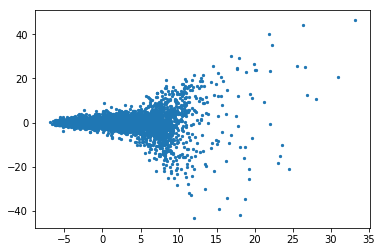

In [28]:
#Create a scatter plot here
plt.scatter(Y_pca[:,0], Y_pca[:,1], s=5)

#SOLUTION
plt.scatter(Y_pca[:, 0], Y_pca[:, 1], s= 5)
### not sure I get this; you are plotting rows and columns of the PCA model?

In [29]:
print(type(Y_pca))
print(Y_pca.shape)

<class 'numpy.ndarray'>
(6122, 2)


__Question__: What do each point represent? What do the x and y axes represent?

__ANSWER__: Each point represents a word. Explanation for axes are below as a part of the lab: (aren't the axes the two principal components?)

You might at this point still be confused on what the x- and y- axes represent. Because PCA selects and combines features according to what best describes and models the desired variable, the x and y axes actually don't have an intuitive meaning on a human level. PCA's job is to reduce the dimension of the features, and in this case it manipulated the 100 features each word vector had to just 2 that best described the words we modeled on. So, don't worry too much about what the coordinates of each word represents - we just want you to have a general visual understanding of word vectors and how they may be related to one another on a graph.

On that note, run the following cell. This will label each vector with its respective word. Can you figure out, in general, what the code is doing?

/Users/jmarshall/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


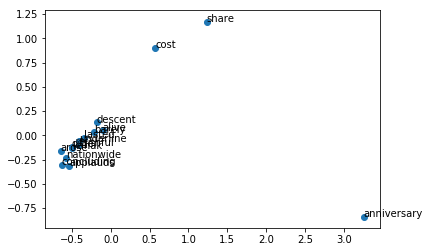

In [30]:
import random
rando = random.sample(list(model.wv.vocab), 15)

X1 = model[rando]
pca1 = PCA(n_components=2)
result = pca.fit_transform(X1)
# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])

for i, word in enumerate(rando):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

*YOUR ANSWER HER*

__ANSWER:__

We are randomly selecting 15 words from the vectors outputted by the model. Then we are using PCA to reduce the dimention to 2 features and standardize the values as we did before. Then we are using matplotlib to create a scatter plot and, for each coordinate of the word, assigning the word label to the coordinate!

Great job! You've now completed the lab on word embeddings and visualizing embeddings with PCA!

---

## Bibliography

- Brownlee, Jason. (2017, October 6). How to Develop Word Embeddings in Python with Gensim. https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

- TensorFlow. (2018, March 29). Vector Representations of Words. https://www.tensorflow.org/tutorials/word2vec
- `rem_punc_stop` function borrowed from Tian Qin's notebook on pre-processig: https://github.com/ds-modules/LEGALST-190/blob/master/labs/3-1/3-1_preprocessing_text_student_version.ipynb
- PCA section adapted from materials by Keeley Takimoto: https://github.com/ds-modules/LEGALST-190/blob/master/labs/3-22/3-22_EDA.ipynb
- Word2Vec introduction & examples adapted from materials by Chris Hench: https://github.com/henchc/textxd-2017/blob/master/08-Word-Embeddings.ipynb



Notebook developed by: Keiko Kamei

Data Science Modules: http://data.berkeley.edu/education/modules